# Comparison of MS partitions and NUTS at baseline

We compare MS partitions with NUTS partitions of the UK and first establish correspondences between MS and NUTS on three levels of hierarchy, fine, medium and coarse. Then we evalute the partitions with the Coverage and Nodal Containment measures.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
import seaborn as sns

import geopandas as gpd
import mercantile
from shapely.geometry import shape

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams.update({'font.size': 20})

In [3]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from network_analysis import compute_indicator_matrix, compute_coverage, compute_coverage_community, compute_nodal_containment
from utils import R2_score, variation_of_information

root_figure = path+"/figures/"
root_map_nuts = path+'/data/geo_shapefiles/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
root_map_ttwa = path+'/data/geo_shapefiles/Travel_to_Work_Areas_Dec_2011_SGCB_in_United_Kingdom_2022_3489023683749467725'
root_processed = path+"/data/processed/"
root_networks = path+"/data/processed/networks/"
root_results = path+"/results/"

## Import baseline network

In [4]:
# load baseline network
A_LSCC = sp.load_npz(root_networks+"baseline_network.npz")
lscc = nx.from_scipy_sparse_matrix(A_LSCC,create_using = nx.DiGraph)

# load node quadkeys
lscc_nodes = []
with open(root_networks+'node_quadkeys.txt', 'r') as filehandle:
    for line in filehandle:
        curr_quadkey = line[:-1]
        lscc_nodes.append(curr_quadkey)
n_nodes = len(lscc_nodes)

## Obtain NUTS and TTWA partitions

In [5]:
# Load NUTS3 data
root_NUTS3 = root_processed+'MOVEMENT_QUADKEY_NUTS3_GB.csv'
df_NUTS = pd.read_csv(root_NUTS3)
print('Shape of NUTS3 data:', df_NUTS.shape)

# Delete _ in front of quadkeys
quadkeys = [df_NUTS['quadkey'][i][1:] for i in range(df_NUTS.shape[0])]

# Get NUTS3 region names
NUTS3 = df_NUTS.columns.values.tolist()[1:]

# Get NUTS2 regions
to_NUTS2 = {NUTS3[i] : NUTS3[i][:4] for i in range(len(NUTS3))}
NUTS2_index = {list(to_NUTS2.values())[i] : i for i in range(len(to_NUTS2))}

# Get NUTS1 regions
to_NUTS1 = {NUTS3[i] : NUTS3[i][:3] for i in range(len(NUTS3))}
NUTS1_index = {list(to_NUTS1.values())[i] : i for i in range(len(to_NUTS1))}

# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)
print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_NUTS3 = {quadkeys[i] : max_rule[i] for i in range(df_NUTS.shape[0])}

# Generate NUTS3 Id's for LSCC nodes
NUTS3_id = np.asarray([quadkey_NUTS3[lscc_nodes[i]] for i in range(n_nodes)])
print('NUTS3 communities in LSCC:', len(set(NUTS3_id)))

# Generate NUTS2 Id's
NUTS2_id = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS2 communities in LSCC:', len(set(NUTS2_id)))

# Generate NUTS1 Id's
NUTS1_id = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS1 communities in LSCC:', len(set(NUTS1_id)))

Shape of NUTS3 data: (3125, 180)
The max is obtained in average with: 0.92
NUTS3 communities in LSCC: 170
NUTS2 communities in LSCC: 42
NUTS1 communities in LSCC: 12


In [6]:
# Load TTWA data
root_TTWA = root_processed+'MOVEMENT_QUADKEY_TTWA_GB.csv'
df_TTWA = pd.read_csv(root_TTWA)
print('Shape of TTWA data:', df_TTWA.shape)

# Compute for each quadkey TTWA region by max vote 
X = np.asarray(df_TTWA.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)
print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to TTWA region id's
quadkey_TTWA = {quadkeys[i] : max_rule[i] for i in range(df_TTWA.shape[0])}

# Generate TTWA Id's for LSCC nodes
TTWA_id = np.asarray([quadkey_TTWA[lscc_nodes[i]] for i in range(n_nodes)])
print('TTWA communities in LSCC:', len(set(TTWA_id)))

Shape of TTWA data: (3125, 229)
The max is obtained in average with: 0.92
TTWA communities in LSCC: 197


In [7]:
# obtain partition indicator matrices
NUTS_TTWA_partitions = []

for node_id in [NUTS3_id,NUTS2_id,NUTS1_id,TTWA_id]:
    H = compute_indicator_matrix(node_id)
    # delete empty columns
    H = H[:, np.sum(H, axis=0) > 0]
    NUTS_TTWA_partitions.append(H)

In [8]:
# statistics for NUTS
partition_names = []
rank_partitions = []
max_c = []
Q1_c = []
Q2_c = []
Q3_c = []
min_c = []

for i in range(4):
    level = "NUTS {}".format(2-i+1)
    if i == 3:
        level = "TTWA"
    partition_names.append(level)
    partition = NUTS_TTWA_partitions[i]
    n_communities = np.linalg.matrix_rank(partition)
    rank_partitions.append(n_communities)
    community_sizes = np.sum(partition, axis=0)
    max_c.append(int(np.max(community_sizes)))
    Q1_c.append(int(np.percentile(community_sizes, q =25)))
    Q2_c.append(int(np.percentile(community_sizes, q =50)))
    Q3_c.append(int(np.percentile(community_sizes, q =75)))
    min_c.append(int(np.min(community_sizes)))
    
community_stats = pd.DataFrame({'Level' : partition_names, 'n_communities' : rank_partitions, 'min_size' : min_c,
                                'Q1':Q1_c, 'Q2' : Q2_c, 'Q3' : Q3_c, 'max_size' : max_c})

In [9]:
community_stats

,Level,n_communities,min_size,Q1,Q2,Q3,max_size
0,NUTS 3,170,1,4,13,27,102
1,NUTS 2,42,1,40,72,102,238
2,NUTS 1,12,44,230,254,324,422
3,TTWA,197,1,9,14,20,60


## Comparison of MS partitions with NUTS and TTWA via NVI

In [10]:
# Load data (deserialize)
with open(root_results+'MS_results.pkl', 'rb') as handle:
    all_results = pickle.load(handle)

# Get times
times = all_results['times']
min_time = all_results['run_params']['min_time']
max_time = all_results['run_params']['max_time']
n_time = all_results['run_params']['n_time']
log_times = np.linspace(min_time,max_time,n_time)

# Get information about communities
community_id = np.asarray(all_results['community_id'])
n_communities  = np.asarray(all_results['number_of_communities'])
n_times = len(n_communities)

In [11]:
community_id_ranked = community_id.copy()

for time in range(n_times):
    # Compute sizes of each community
    labels_graph_counts = np.histogram(community_id[time],bins=np.arange(0,n_communities[time]+1)) [0]
    # Get class indices sorted according to size
    community_ranked = np.argsort(-labels_graph_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {community_ranked[k] : k for k in range(0,n_communities[time])}
    # Apply permutation to labels
    labels_community = community_id[time].copy()
    for i in range (0,len(labels_community)):
        labels_community[i] = rank[labels_community[i]]
    
    community_id_ranked[time] = labels_community

In [12]:
nvi_NUTS3 = []
nvi_TTWA = []


for time in range(n_time):
    nvi_NUTS3.append(variation_of_information(community_id_ranked[time],NUTS3_id))
    nvi_TTWA.append(variation_of_information(community_id_ranked[time],TTWA_id))

nvi_NUTS3 = np.asarray(nvi_NUTS3)
nvi_TTWA = np.asarray(nvi_TTWA)

In [13]:
# Compute optimal times for NVI
nvi_t_NUTS3 = log_times[np.argmin(nvi_NUTS3)]
nvi_NUTS3_min = np.min(nvi_NUTS3)
print('Optimal Markov time for NUTS3:', np.around(nvi_t_NUTS3,2), 'with NVI', 
      np.around(nvi_NUTS3_min,2))
nvi_t_TTWA = log_times[np.argmin(nvi_TTWA)]
nvi_TTWA_min = np.min(nvi_TTWA)
print('Optimal Markov time for TTWA:', np.around(nvi_t_TTWA,2), 'with NVI', 
      np.around(nvi_TTWA_min,2))

Optimal Markov time for NUTS3: -1.63 with NVI 0.27
Optimal Markov time for TTWA: -1.6 with NVI 0.21


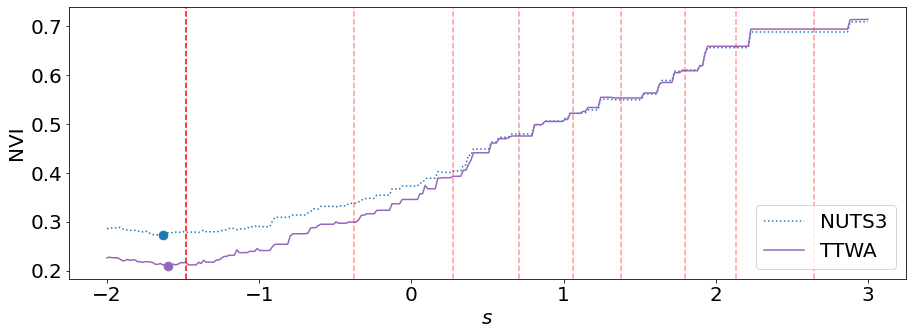

In [14]:
robust_scales = all_results["selected_partitions"]

# Plot
fig, ax = plt.subplots(1,figsize =(15,5))

ax.plot(log_times,nvi_NUTS3, label = 'NUTS3',ls=":")
ax.plot(log_times,nvi_TTWA, label = 'TTWA', c="C4")

ax.scatter(nvi_t_NUTS3,nvi_NUTS3_min,marker='.',s=300)
ax.scatter(nvi_t_TTWA,nvi_TTWA_min,marker='.',s=300, c="C4")

for i in robust_scales:
    if i in [robust_scales[0]]:
        ax.axvline(x = log_times[i], ls="--", color = 'red')
    else:
        ax.axvline(x = log_times[i], ls="--", color = 'red', alpha = 0.4)



ax.set(xlabel = r"$s$",ylabel = 'NVI') #,sitle='Similarity between Markov Stability partitions and NUTS regions')
        #yticks = [0.3,0.5,0.7] ) 
ax.legend(loc=4)
plt.show()

fig.savefig(root_figure +'MS_NUTS_TTWA_matching.pdf', dpi=fig.dpi,bbox_inches='tight')

In [15]:
# select the three MS partitions most similar to NUTS
MS0_id = np.asarray(all_results['community_id'][robust_scales[0]])
MS1_id = np.asarray(all_results['community_id'][robust_scales[1]])
MS3_id = np.asarray(all_results['community_id'][robust_scales[3]])

MS_partitions = []

for node_id in [MS0_id,MS1_id,MS3_id]:
    H = compute_indicator_matrix(node_id)
    MS_partitions.append(H)

In [16]:
print("NVI between NUTS3 and fine MS:", np.around(nvi_NUTS3[robust_scales[0]],3))
print("NVI between TTWA and fine MS:", np.around(nvi_TTWA[robust_scales[0]],3))
print("\nNVI between TTWA and NUTS3:",np.around(variation_of_information(TTWA_id,NUTS3_id),2))
print("NVI between TTWA and NUTS2:",np.around(variation_of_information(TTWA_id,NUTS2_id),2))
print("NVI between TTWA and NUTS1:",np.around(variation_of_information(TTWA_id,NUTS1_id),2))

NVI between NUTS3 and fine MS: 0.278
NVI between TTWA and fine MS: 0.217

NVI between TTWA and NUTS3: 0.28
NVI between TTWA and NUTS2: 0.39
NVI between TTWA and NUTS1: 0.55


## Visualise MS / TTWA overlay

In [17]:
# Load optimal partitions in the format of sets
with open(root_results+'MS_optimal_partitions.pkl', 'rb') as handle:
    MS_partitions_sets = pickle.load(handle)

In [18]:
# Import TTWA shape files
gdf_ttwa = gpd.read_file(root_map_ttwa)
gdf_ttwa = gdf_ttwa.to_crs("EPSG:3395")

# remove Scotish islands
gdf_ttwa=gdf_ttwa[~gdf_ttwa['TTWA11NM'].isin(['Orkney Islands', 'Shetland Islands'])]
gdf_ttwa.reset_index(drop=True,inplace=True)

201


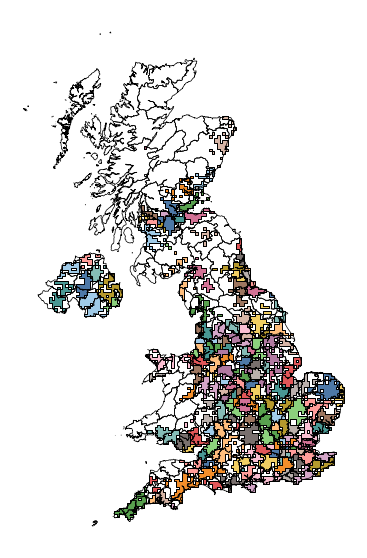

In [19]:
# select fine MS partition
comms_list = MS_partitions_sets[0]
tile_list = []

for j in comms_list:
    tile_list = tile_list+list(j)

#print(len(tile_list))

polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in tile_list:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf_lscc = gpd.GeoDataFrame({'geometry':geom, 'quadkey':tile_list}, crs = "EPSG:4326")
gdf_lscc = gdf_lscc.to_crs("EPSG:3395")

gdf_lscc['COMM'] = None

print(len(comms_list))

for j in range(0,len(comms_list)):

    gdf_lscc.loc[gdf_lscc['quadkey'].isin(comms_list[j]), 'COMM'] = j

gdf_lscc_diss = gdf_lscc.dissolve(by = 'COMM')

tab_20 = ['#4E79A7', '#A0CBE8', '#F28E2B', '#FFBE7D', '#59A14F',
            '#8CD17D', '#B6992D', '#F1CE63', '#499894', '#86BCB6',
            '#E15759', '#FF9D9A', '#79706E', '#BAB0AC', '#D37295',
            '#FABFD2', '#B07AA1', '#D4A6C8', '#9D7660', '#D7B5A6']

while len(tab_20) < np.max(gdf_lscc['COMM']):
    tab_20 = tab_20+tab_20

df_color = pd.DataFrame(tab_20)
df_color.columns = ['COLOR']
df_color = df_color.reset_index()

df_color.columns = ['COMM', 'COLOR']
gdf_lscc = pd.merge(gdf_lscc,df_color,how='left', on = 'COMM')
gdf_lscc_diss = pd.merge(gdf_lscc_diss,df_color,how='left', on = 'COMM')

f, ax = plt.subplots(1, figsize=(20,10))
gdf_lscc_diss.plot(linewidth=1, ax=ax, edgecolor= 'black', facecolor = gdf_lscc_diss['COLOR'])
gdf_ttwa.plot(linewidth=0.7,ax=ax, facecolor = 'none')
ax.set_axis_off()
plt.savefig(root_figure+'CLUSTER_TTWA.pdf', bbox_inches = 'tight')
plt.show()

## Comparison of Coverage of partitions

In [20]:
coverage_NUTS_TTWA = 100*np.array([compute_coverage(lscc,NUTS_TTWA_partitions[0]),compute_coverage(lscc,NUTS_TTWA_partitions[1]),compute_coverage(lscc,NUTS_TTWA_partitions[2]),compute_coverage(lscc,NUTS_TTWA_partitions[3])])
coverage_MS = 100*np.array([compute_coverage(lscc,MS_partitions[0]),compute_coverage(lscc,MS_partitions[1]),compute_coverage(lscc,MS_partitions[2])])

In [21]:
print("Average Coverage of NUTS3:", np.around(coverage_NUTS_TTWA[0],1))
print("Average Coverage of TTWA:", np.around(coverage_NUTS_TTWA[3],1))
print("Average Coverage of fine MS:", np.around(coverage_MS[0],1))

Average Coverage of NUTS3: 90.1
Average Coverage of TTWA: 95.9
Average Coverage of fine MS: 92.1


## Comparison of average Nodal Containment

In [22]:
# Compute Containment
NC_NUTS3 = compute_nodal_containment(lscc,NUTS3_id)
NC_TTWA = compute_nodal_containment(lscc,TTWA_id)
NC_MS0 = compute_nodal_containment(lscc,MS0_id)

In [23]:
print("Average NC of NUTS3:", np.around(100*np.mean(NC_NUTS3),1))
print("Average NC of TTWA:", np.around(100*np.mean(NC_TTWA),1))
print("Average NC of fine MS:", np.around(100*np.mean(NC_MS0),1))

Average NC of NUTS3: 72.8
Average NC of TTWA: 81.3
Average NC of fine MS: 86.6


## Summary Box Plots for Coverage on community level and Nodal Containment

In [24]:
# Compute Coverage on community level
coverage_k_NUTS3 = compute_coverage_community(lscc,NUTS_TTWA_partitions[0])
coverage_k_TTWA = compute_coverage_community(lscc,NUTS_TTWA_partitions[3])
coverage_k_MS0 = compute_coverage_community(lscc,MS_partitions[0])

In [25]:
from matplotlib.patches import Patch

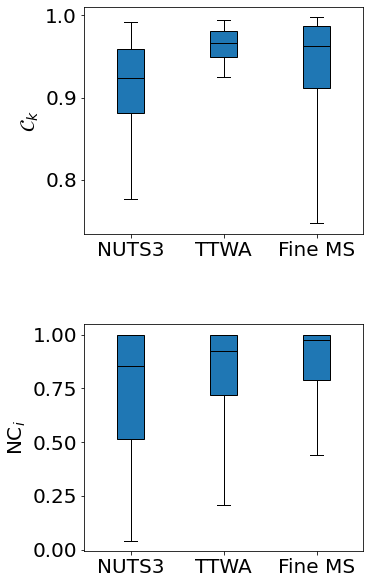

In [26]:
fig = plt.figure(figsize=(5,10))
fig.subplots_adjust(wspace=0.3,hspace=0.4)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

x = np.arange(3)
offset=0#0.14
xticklabels = ['NUTS3','TTWA','Fine MS']

legend_elements = [Patch(facecolor='tab:blue', edgecolor='black',label='NUTS&TTWA'),Patch(facecolor='tab:orange', edgecolor='black',label='MS')]


box_param = dict(whis=(5, 95), widths=0.3, patch_artist=True,
                 flierprops=dict(marker='.', markeredgecolor='black',
                 fillstyle=None), medianprops=dict(color='black'),
                 meanprops=dict(marker='.',ms=15,mfc='red', markeredgecolor='black',
                 fillstyle=None))

ax1.boxplot(np.asarray([coverage_k_NUTS3,coverage_k_TTWA,coverage_k_MS0]),positions=x-offset,notch=False,showfliers=False, showmeans=False,**box_param)
ax1.set(xticks=x,xticklabels=xticklabels,ylabel=r'$\mathcal{C}_k$')
# ax1.legend(handles=legend_elements)

ax2.boxplot(np.asarray([NC_NUTS3,NC_TTWA,NC_MS0]).transpose(),positions=x-offset,notch=False,boxprops=dict(facecolor='tab:blue'),showfliers=False, showmeans=False, **box_param)
ax2.set(xticks=x,xticklabels=xticklabels,ylabel=r'NC$_i$')
# ax2.legend(handles=legend_elements)

plt.show()

fig.savefig(root_figure+'comparison_boxplots_with_TTWA.pdf', dpi=fig.dpi,bbox_inches='tight')

## Statistical tests

In [27]:
# apply Mann-Whitney U test
from scipy.stats import mannwhitneyu

print('NUTS3/Fine MS')
U, p_f_coverage = mannwhitneyu(coverage_k_NUTS3,coverage_k_MS0)
print('Coverage: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_coverage)
U, p_f_nc = mannwhitneyu(NC_NUTS3,NC_MS0)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_nc)

print('\nTTWA/Fine MS')
U, p_f_coverage = mannwhitneyu(coverage_k_TTWA,coverage_k_MS0)
print('Coverage: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_coverage, "-> not significant")
U, p_f_nc = mannwhitneyu(NC_TTWA,NC_MS0)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_nc)

print('\nTTWA/NUTS3')
U, p_f_coverage = mannwhitneyu(coverage_k_TTWA,coverage_k_NUTS3)
print('Coverage: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_coverage)
U, p_f_nc = mannwhitneyu(NC_TTWA,NC_NUTS3)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_nc)

NUTS3/Fine MS
Coverage: Mann-Whitney U test rejects null hypothesis with p-value:  1.715334709894178e-07
NC: Mann-Whitney U test rejects null hypothesis with p-value:  4.1806453432159544e-54

TTWA/Fine MS
Coverage: Mann-Whitney U test rejects null hypothesis with p-value:  0.1687854843725971 -> not significant
NC: Mann-Whitney U test rejects null hypothesis with p-value:  1.0531104240750691e-14

TTWA/NUTS3
Coverage: Mann-Whitney U test rejects null hypothesis with p-value:  5.047264029554989e-20
NC: Mann-Whitney U test rejects null hypothesis with p-value:  6.416280864400018e-17
